<a href="https://colab.research.google.com/github/nimendra-ag/Deep-Learning-NLP-for-Sentiment-analysis-Translation/blob/main/Sentiment_Analysis_Neuralearn_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install gensim

In [6]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [7]:
BATCH_SIZE=64

# Data Prepratation

In [110]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)

In [111]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [112]:
for review,label in train_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [113]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase = tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")  #removing html tags
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [12]:
from nltk.stem.porter import PorterStemmer

In [13]:
PorterStemmer().stem("discussion")

'discuss'

In [14]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [114]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [115]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [17]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(10):
#   for word in tf.strings.split(review, sep=" "):
#     if word in words:
#       pass
#     else:
#       words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [18]:
# print(len(words))
# print(lengths)

In [116]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [20]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'more',
 'very',
 'when',
 'she',
 'even',
 'up',
 'no',
 'would',
 'my',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'been',
 'get',
 'well',
 'will',
 'into',
 'because',
 'people',
 'other',
 'also',
 'do',
 'bad',
 'great',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'movies',
 'then',
 'films',
 'make',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'plot',
 'where',
 'best',
 '

In [21]:
for review, label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [22]:
def vectorizer(review, label):
  return vectorize_layer(review), label

In [23]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [24]:
for review, label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [117]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

## SimpleRNN

In [26]:
inputs=np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25)
output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [27]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4985 - loss: 0.6946

391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.4985 - loss: 0.6946 - val_accuracy: 0.4985 - val_loss: 0.6949
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 152ms/step - accuracy: 0.5584 - loss: 0.6835 - val_accuracy: 0.4985 - val_loss: 0.6965
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 76s 137ms/step - accuracy: 0.6194 - loss: 0.6612 - val_accuracy: 0.4937 - val_loss: 0.7041
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7100 - loss: 0.6057

391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 127ms/step - accuracy: 0.7101 - loss: 0.6056 - val_accuracy: 0.4994 - val_loss: 0.7191
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7765 - loss: 0.5348

391/391 ━━━━━━━━━━━━━━━━━━━━ 71s 98ms/step - accuracy: 0.7765 - loss: 0.5347 - val_accuracy: 0.5068 - val_loss: 0.7364
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8180 - loss: 0.4695

391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.8180 - loss: 0.4695 - val_accuracy: 0.5074 - val_loss: 0.7511
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8413 - loss: 0.4338

391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - accuracy: 0.8413 - loss: 0.4338 - val_accuracy: 0.5088 - val_loss: 0.7559
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.8470 - loss: 0.4155 - val_accuracy: 0.5071 - val_loss: 0.7791
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8415 - loss: 0.4225

391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.8416 - loss: 0.4224 - val_accuracy: 0.5109 - val_loss: 0.8044
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.8800 - loss: 0.3587 - val_accuracy: 0.5098 - val_loss: 0.8596


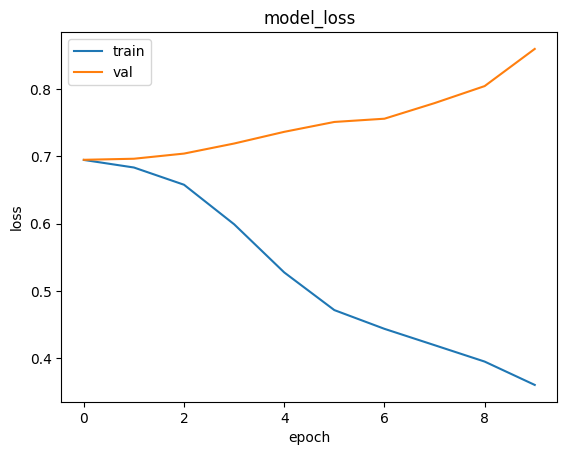

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

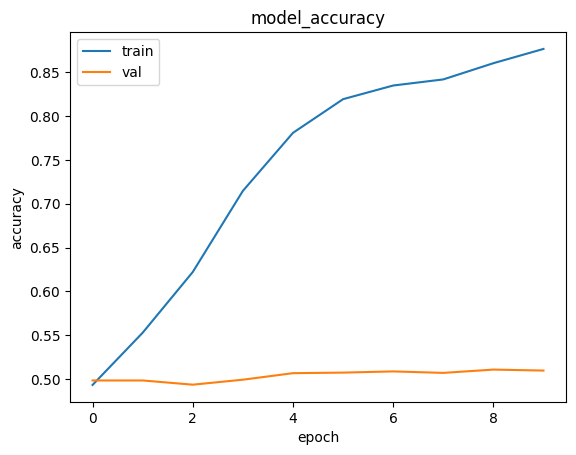

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [33]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.6555 - loss: 0.6607


[0.558538019657135, 0.7297599911689758]

## LSTM (MultiLayer and Bidirectional)

In [34]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']
              )

In [38]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.5300 - loss: 0.6855

391/391 ━━━━━━━━━━━━━━━━━━━━ 321s 791ms/step - accuracy: 0.5302 - loss: 0.6854 - val_accuracy: 0.7963 - val_loss: 0.4400
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8436 - loss: 0.3779

391/391 ━━━━━━━━━━━━━━━━━━━━ 290s 713ms/step - accuracy: 0.8437 - loss: 0.3778 - val_accuracy: 0.8545 - val_loss: 0.3467
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8993 - loss: 0.2696

391/391 ━━━━━━━━━━━━━━━━━━━━ 279s 713ms/step - accuracy: 0.8993 - loss: 0.2696 - val_accuracy: 0.8645 - val_loss: 0.3367
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 277s 709ms/step - accuracy: 0.9223 - loss: 0.2235 - val_accuracy: 0.8625 - val_loss: 0.3666
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 270s 691ms/step - accuracy: 0.9277 - loss: 0.2060 - val_accuracy: 0.8546 - val_loss: 0.3888
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 277s 708ms/step - accuracy: 0.9329 - loss: 0.1928 - val_accuracy: 0.8594 - val_loss: 0.4039
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 282s 722ms/step - accuracy: 0.9400 - loss: 0.1723 - val_accuracy: 0.8540 - val_loss: 0.4485
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 298s 763ms/step - accuracy: 0.9477 - loss: 0.1578 - val_accuracy: 0.8445 - val_loss: 0.4678
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 304s 778ms/step - accuracy: 0.9567 - loss: 0.1353 - val_accuracy: 0.8444 - val_loss: 0.4462
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 310s 747ms/step - accuracy: 0.9650 - loss: 0.1

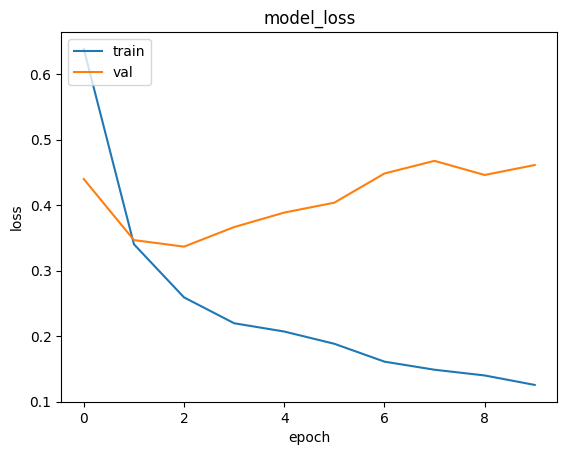

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

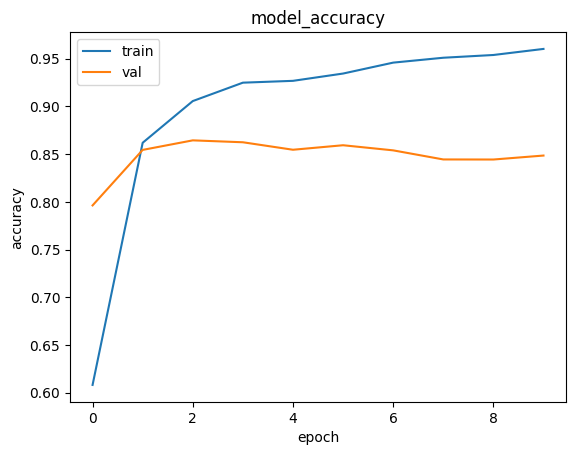

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [41]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.8489 - loss: 0.4574


[0.4561425447463989, 0.8483999967575073]

## GRU (MultiLayer and Bidirectional)

In [42]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 250, 128)            │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [45]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 339s 841ms/step - accuracy: 0.5063 - loss: 0.6929 - val_accuracy: 0.5785 - val_loss: 0.6853
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 322s 824ms/step - accuracy: 0.6879 - loss: 0.5848 - val_accuracy: 0.8404 - val_loss: 0.3665
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 817ms/step - accuracy: 0.8743 - loss: 0.3182 - val_accuracy: 0.8457 - val_loss: 0.3619
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 815ms/step - accuracy: 0.9066 - loss: 0.2477 - val_accuracy: 0.8450 - val_loss: 0.3771
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 322s 816ms/step - accuracy: 0.9241 - loss: 0.2155 - val_accuracy: 0.8543 - val_loss: 0.3759
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 817ms/step - accuracy: 0.9282 - loss: 0.2007 - val_accuracy: 0.8510 - val_loss: 0.4155
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 817ms/step - accuracy: 0.9346 - loss: 0.1838 - val_accuracy: 0.8506 - val_loss: 0.4425
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 326s 827ms/step - accuracy: 0.9489 -

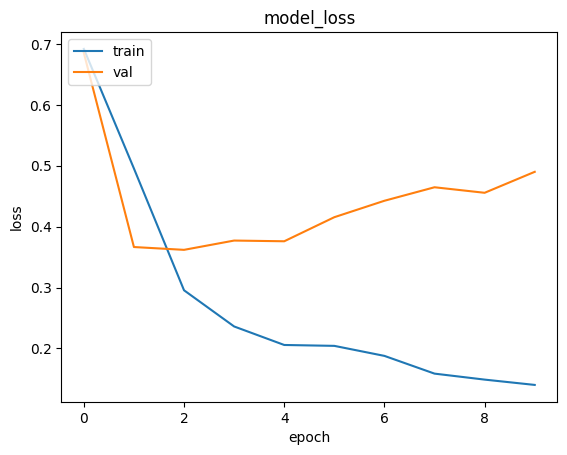

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

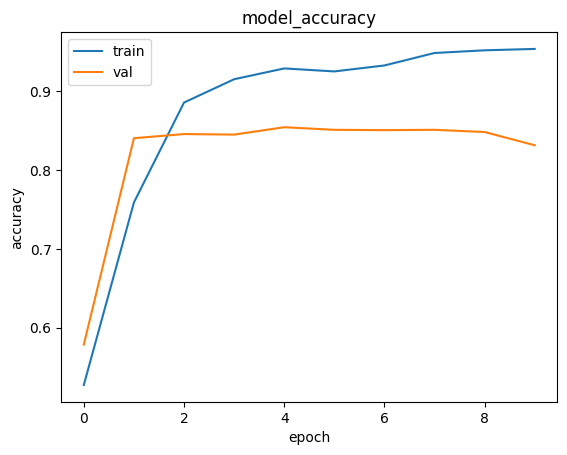

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [48]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - accuracy: 0.8281 - loss: 0.5079


[0.5003913044929504, 0.8286399841308594]

## Conv1D

In [49]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,), dtype="int64"),  # Added input shape here
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [52]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'],
              run_eagerly=True)

In [53]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.4994 - loss: 0.6932

391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 280ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.5486 - val_loss: 0.6896
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6335 - loss: 0.6416

391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 282ms/step - accuracy: 0.6337 - loss: 0.6414 - val_accuracy: 0.8514 - val_loss: 0.3602
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8667 - loss: 0.3258

391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 280ms/step - accuracy: 0.8667 - loss: 0.3257 - val_accuracy: 0.8712 - val_loss: 0.3114
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 107s 275ms/step - accuracy: 0.9129 - loss: 0.2365 - val_accuracy: 0.8682 - val_loss: 0.3144
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 269ms/step - accuracy: 0.9363 - loss: 0.1852 - val_accuracy: 0.8645 - val_loss: 0.3437
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 114s 292ms/step - accuracy: 0.9502 - loss: 0.1509 - val_accuracy: 0.8611 - val_loss: 0.3622
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 293ms/step - accuracy: 0.9588 - loss: 0.1325 - val_accuracy: 0.8590 - val_loss: 0.3792
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 132s 268ms/step - accuracy: 0.9621 - loss: 0.1155 - val_accuracy: 0.8509 - val_loss: 0.4128
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 115s 294ms/step - accuracy: 0.9718 - loss: 0.0972 - val_accuracy: 0.8583 - val_loss: 0.4073
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 114s 292ms/step - accuracy: 0.9800 - loss: 0.0

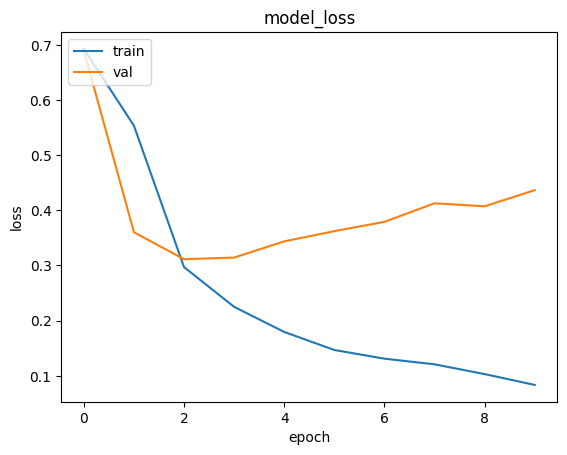

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

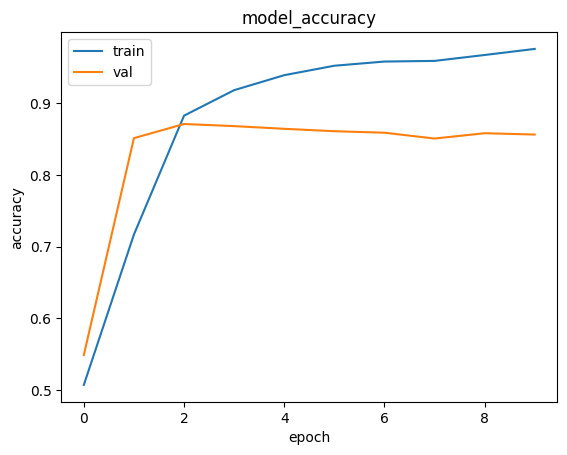

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [56]:
model.load_weights(checkpoint_filepath)

In [57]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.8660 - loss: 0.3150


[0.31533119082450867, 0.8654400110244751]

## Pretrained Word2vec[Gensim]

In [118]:
word2vec=api.load('word2vec-google-news-300')

In [64]:
print(word2vec.vectors.shape)

(3000000, 300)


In [68]:
vector = word2vec["king"]
print(vector)

[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

In [77]:
vector = word2vec[word2vec.index_to_key[2]]
print(vector.shape)

(300,)


In [89]:
word2vec.most_similar('man')

[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

In [119]:
pretrained_embeddings = []

In [120]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [121]:
len(vectorize_layer.get_vocabulary())

10000

In [122]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
and
toupper
a
toupper
of
toupper
to
toupper
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
iis==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
toupper
100
nosolution
hasnt
nosolution
90
nosolution
shouldnt
nosolution
favourite
toupper
theatre
toupper
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
toupper
50
nosolution
90s
nosolution
1950s
nosolution
iis==================================== 2000
keaton
toupper
welles
toupper
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
toupper
columbo
toupper
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
toupper
pacino
toupper
moviethe
nosolution
writerdirector
nosolution
itthe
nosolution
lugosi
toupper
hitchcock
toupper
810
nosolution
iis===================

In [123]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [124]:
np.save('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)

In [125]:
pretrained_embeddings_array=np.load('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings.npy')

In [126]:
pretrained_embeddings_array.shape

(10000, 300)

In [127]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [129]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [130]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_8_1/Cast:0", shape=(None, None, None, None), dtype=float32). Expected shape (None, 250), but input has incompatible shape (None, None, None, None)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, None, None), dtype=int64)
  • training=True
  • mask=None

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)